# Notebook for NSREC publication plots
A collections of analyses and plots for our NSREC paper. As multiple data sets are imported, I am adding caching of parsed data in for of pickle files to save some time. 

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.data_interface import DataInterface
from src.analysis.base_tools import BaseTools
from src.analysis.ibex_coremark_tools import IbexCoremarkTools
from src.analysis.ibex_hwsec_coremark_tools import IbexHwsecCoremarkTools
from src.run_info.run_info import RunInfo
from typing import List, Tuple, NamedTuple
from src.analysis.structures.seu_log import SeuLog
from src.analysis.structures.node import Node

import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import comb
from anytree.exporter import DotExporter

def visualization_setup():
    # Interactive plots. Requires tkinter on the machine running the code
    mpl.use("TkAgg")
    # Latex formatting for plots. Some visualizations might not work without this
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parse data sets
* Only run this if data has changed. Takes a loooong time
* If re-parsing within a notebook, its recommended to restart the kernel

In [17]:
""" 
Declare which data sets you want to parse in a dict, so they can be looped thru.
 
The key is the name of the data set, the value is a list with the run_info file and 
a boolean indicating if the raw data is to be parsed and cached. 
"""

data_set_info = {
    "baseline"          : ["src/run_info/ibex_coremark.ini", 0],  
    "RV32MSingleCycle"  : ["src/run_info/ibex_RV32MSingleCycle_coremark.ini", 0]
}

In [18]:
class SeuDataSet(NamedTuple):
    root: RunInfo
    node: Tuple[Node]
    root_data: SeuLog
    node_data: SeuLog
    golden: pd.Series
    data_interface: DataInterface

for data_set, runinfo_path in data_set_info.items():
    if runinfo_path[1]: 
        runinfo = RunInfo(runinfo_path[0])
        data_interface = DataInterface(runinfo)
        golden = data_interface.golden_log
        node = data_interface.get_node_by_name("register_file_i")[0]
        root = data_interface.root
        node_data = data_interface.get_seu_log_by_node(node)
        root_data = data_interface.get_seu_log_by_node(root)
        node_runs = list(node_data.index)

        save = SeuDataSet(root, node, root_data, node_data, golden, data_interface)
        
        try:
            pickle.dump(save, open(f"cache/{data_set}.pickle", "wb"))
            print(f"Saved {data_set}.pickle to cache.")
        except Exception as e:
            print(e)
            print(f"Could not save {data_set}.pickle to cache.")


## Load Cached Data

In [19]:
# load data sets from cache
data_sets = {name : pickle.load(open(f"cache/{name}.pickle", "rb")) for name in data_set_info.keys()}
# print(data_sets)

{'baseline': SeuDataSet(root=Node('/ibex_soc_wrap', soc_path='ibex_soc_wrap'), node=Node('/ibex_soc_wrap/ibex_soc_i/ibex_wrap/u_top/u_ibex_top/gen_regfile_ff/register_file_i', soc_path='ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibex_top.gen_regfile_ff.register_file_i'), root_data=                               vpi_bits  \
seu_2024-01-09_21-25-53.806663     2806   
seu_2024-01-09_06-45-18.210182     2806   
seu_2024-01-09_23-40-32.881994     2806   
seu_2024-01-10_12-15-35.060420     2806   
seu_2024-01-09_04-32-36.667590     2806   
...                                 ...   
seu_2024-01-11_04-22-08.997654     2806   
seu_2024-01-10_04-29-50.204599     2806   
seu_2024-01-09_05-13-35.527828     2806   
seu_2024-01-10_22-11-43.549870     2806   
seu_2024-01-09_18-40-20.307191     2806   

                                                                         register  \
seu_2024-01-09_21-25-53.806663  ibex_soc_wrap.ibex_soc_i.ibex_wrap.u_top.u_ibe...   
seu_2024-01-09_06-45-18.210182 

## Analyses

In [20]:

import matplotlib.pyplot as plt

plt.rcParams.update({
    # 'font.family': 'serif',
    # 'font.serif': ['Times', 'Palatino', 'New Century Schoolbook', 'Bookman', 'Computer Modern Roman'],
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'figure.figsize': [3.39, 2.10],
    'lines.linewidth': 1.0,
    'lines.markersize': 4,
    'lines.markeredgewidth': 0.5,
    'lines.markeredgecolor': 'black',
    'lines.markerfacecolor': 'black'
    # 'text.usetex': True,
    # 'text.latex.preamble': r'\usepackage{amsmath}'
})

# _ = BaseTools.error_classification_confidence(data_interface, data_sets["RV32MSingleCycle"].root, visualize=True)
# _ = BaseTools.error_classification_confidence(data_interface, data_sets["RV32MSingleCycle"].node, visualize=True)

### Grouped bar plots
Group by error

Data set: baseline
Number of entries on node_data: 13971
Number of entries on root_data: 40455
NE      36123
SDC      3058
SEFI     1274
Name: count, dtype: int64
Totals of baseline: 40455
Data set: RV32MSingleCycle
Number of entries on node_data: 32213
Number of entries on root_data: 94587
NE      84481
SDC      7028
SEFI     3078
Name: count, dtype: int64
Totals of RV32MSingleCycle: 94587


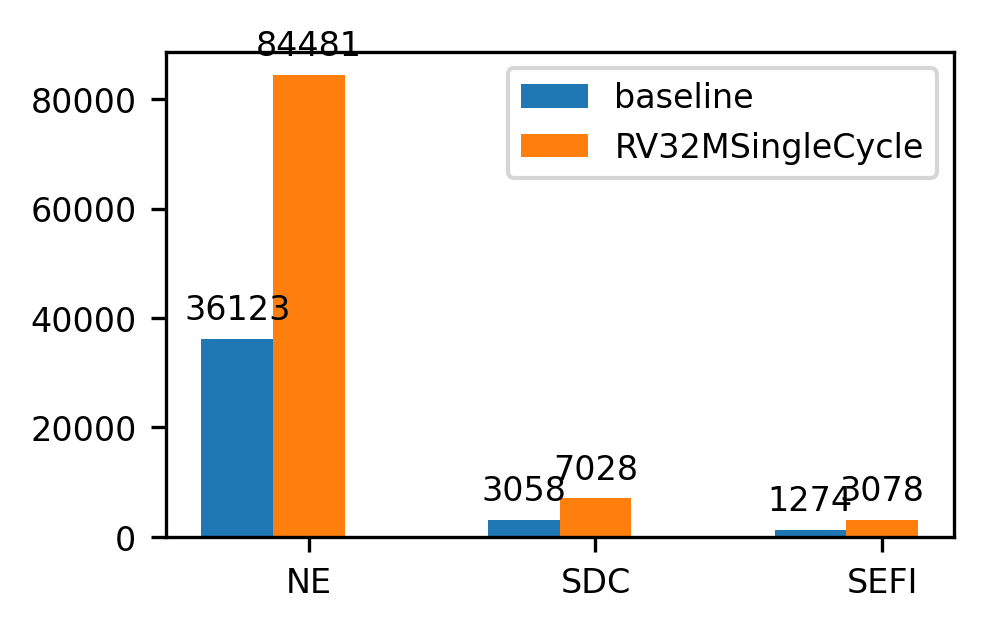

In [102]:
# Define the number of groups and members per group
num_groups = len(data_sets.keys())
members_per_group = 3

from src.analysis.structures.error_definitions import (
    SilentError,
    DataCorruptionError,
    CriticalError,
    BaseError,
)

# Define the x-axis tick locations
x_tick_locs = np.arange(members_per_group)

bar_width = 0.25
multiplier = 0

fig, ax = plt.subplots()

# Multi bar plot grouped by error outcome
for name, data_set in data_sets.items():

    print(f"Data set: {name}")
    print(f"Number of entries on node_data: {len(data_set.node_data)}")
    print(f"Number of entries on root_data: {len(data_set.root_data)}")

    # get error outcomes
    data = BaseTools.error_classification(data_set.data_interface, data_set.root, visualize=False)
    # count unique values
    counts = data.value_counts()
    print(counts)
    print(f"Totals of {name}: {counts.sum()}")

    offset  = bar_width * multiplier
    rects = ax.bar(x_tick_locs + offset, counts, width=bar_width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x_tick_locs + (members_per_group - 1) * bar_width / 2)
ax.set_xticklabels(counts.index)

ax.legend()
plt.show()




Group by config

                        NE       SDC      SEFI
baseline          0.892918  0.075590  0.031492
RV32MSingleCycle  0.893157  0.074302  0.032541


[Text(0, 0, 'baseline'), Text(1, 0, 'fast_mult')]

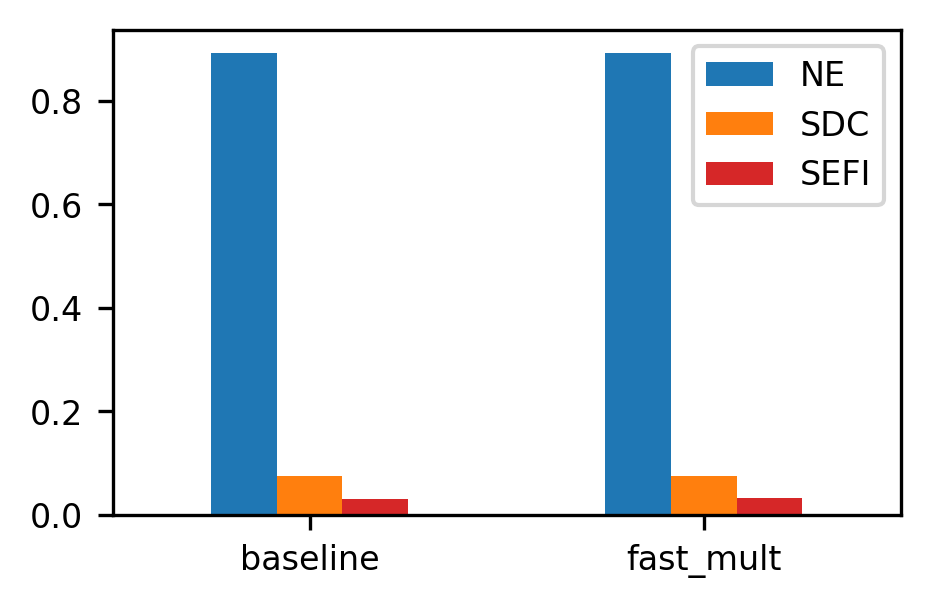

In [170]:
x_tick_locs = np.arange(len(data_sets.keys()))
# provide which errors are to be plotted
errors_classes_to_plot = [SilentError, DataCorruptionError, CriticalError]
transpose = 1

plot_df = pd.DataFrame()

# Multi bar plot grouped by configuration
for name, data_set in data_sets.items():

    # get error outcomes
    data = BaseTools.error_classification(data_set.data_interface, data_set.root, visualize=False)

    # count unique values
    error_class_names  = [error_class.name for error_class in errors_classes_to_plot] # get names
    counts = data[data.isin(error_class_names)].value_counts()
    counts = counts.rename(name)

    # build data to plot
    plot_df = pd.concat([plot_df, counts], axis=1, sort=False)

if transpose:
    plot_df = plot_df.transpose()

# get proportions of each error class against sum of each row
# print(plot_df.sum(axis=1).values())
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0) # proportional

S = 2806 * np.array()

print(plot_df)
ax = plot_df.plot.bar(color=[error_class.color for error_class in errors_classes_to_plot])
legend = ax.get_legend_handles_labels()
ax.set_xticklabels(["baseline", "fast_mult"], rotation=0)


In [173]:
data_sets["baseline"].root

Node('/ibex_soc_wrap', soc_path='ibex_soc_wrap')

/home/anvesh/projects/Ibex-Analysis/src/analysis/ibex_coremark_tools.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


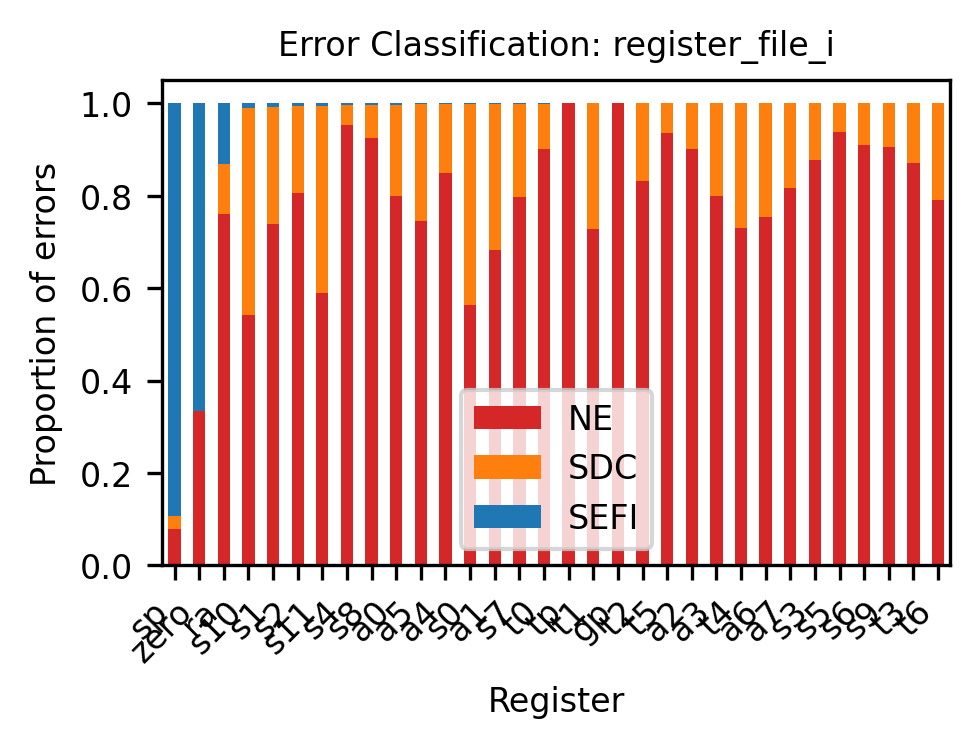

In [ ]:
node = data_interface.get_node_by_name("register_file_i")[0]
node.children
_, fig = IbexCoremarkTools.stacked_register_error_class(
    data_interface, node, visualize=True
)